<h1>MALIS Lab Session 3 - Fall 2019</h1>

The aim of this lab is to practice with Support Vector Machines (SVM), and in particular with the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) algorithm. PEGASOS is a fast stochastic sub-gradient descent algorithm for solving the primal optimization problem cast by an SVM. In the first part of this lab, you will be to implement PEGASOS. As it is based on a primal problem, it is only adapted to linear kernels; the authors of PEGASOS proposed a way to use other non-linear kernels, at the price of time efficiency. Therefore in the second part of the lab, instead of implementing that less efficient version of PEGASOS, you will work on a features mapping method that will allow you to separate non-linearly separable datasets using PEGASOS. You will test your implementations on four datasets.

Experiments should be made by groups of two students. Each group should produce a Jupyter Notebook with all their results and comments. We strongly encourage the addition of plots and visual representations to the report, bearing in mind that comments on graphical data are still necessary. Code for adding images to your notebook: ```<img src="path/to/image.png" />```.

Submit your complete notebook as an archive (tar -cf <last_name_1>_<last_name_2>_notebook.tar lab2/). 

**Deadline for submitting your notebook:** 23 December 2019 23:59 via Moodle.

<h2>Introduction</h2>
There are three parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS;

2. A part on features mapping.

Data are 2D. You can visualize them by running the following cell (purple dots are labeled -1 and yellow dots are labeled 1).

In [0]:
#This cell is only for those running colab
data_path="http://www.eurecom.fr/~zuluaga/data"

import random
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, cos

PI = 3.141592653589793238462643383279502884197169

def sign(x):
    '''
    The sign function (returns -1 if x is negative and 1 if it is non-negative)
    '''
    if x < 0:
        return -1
    else:
        return 1

class Dataset:
    '''
    A class representing a dataset. The first layer of an instance of the MLP class should be a Dataset object.
    '''
    def __init__(self, datafile=None, input_size=0, length=0):
        self.input = []
        self.output = []
        if datafile:
            df = pd.read_csv(datafile)
            self.input =  df[['x', 'y'] ].values
            self.output = (df['label'].values).astype(int)
            self.input_size = len(df.columns) -1
            self.len = len(self.input) # Number of samples in the dataset (accessible through len(dataset))
        else:
            self.input_size = input_size
            self.len = length
        self.indices = list(range(self.len)) # List of indices used to pick samples in a random order

    def next_sample(self):
        '''
        Pick next sample
        '''
        i = random.choice(self.indices)
        return (self.input[i], self.output[i])

    def __len__(self):
        return self.len

class SVM:
    '''
    A class representing a Support Vector Machine
    '''
    def __init__(self, dataset, test_dataset, print_step=None, verbose=False): # infile: MLP description file, dataset: Dataset object
        self.verbose = verbose
        self.dataset = dataset # Current dataset
        self.train_dataset = dataset # Training dataset
        self.test_dataset = test_dataset # Testing dataset
        self.plot = list() # You can use this to make plots
        self.test_plot = list() # Plot for test dataset
        input_size = dataset.input_size
        self.w = np.random.rand(input_size+1)-0.5 # self.w[-1] is actually b
        self.print_step = print_step # Print accuracy during training every print_step
        sample, self.gt = dataset.next_sample() # Initialize input and output of MLP
        self.x = np.array(sample.tolist() + [1.])

    def __str__(self):
        res = "(w = "
        res += str(self.w[:-1])
        res += ", b = "
        res += str(self.w[-1])
        res += ")"
        return res

    def __call__(self):
        res = np.dot(self.w, self.x)
        return res

    def train_one_iteration(self, l, eta_t):
        '''
        Train for one epoch
        '''
        pass

    def train(self, n_iterations, l):
        '''
        Train function (with specified number of epochs, lambda and decay)
        '''
        if not self.print_step:
            self.print_step = max(1, int(n_iterations/50))
        # For n_iterations iterations...
        for i in range(n_iterations):
            # Set the learning rate to 1/((i+1)*l)...
            eta_t = 1/((i+1)*l)
            # And train for one iteration!
            self.train_one_iteration(l, eta_t)

            if not i%(self.print_step):
                if self.verbose:
                    print("Epoch:", i+1, "out of", n_iterations)
                    self.print_accuracy()
                else:
                    self.compute_accuracy()

    def setnextinput(self):
        '''
        Set input of SVM to next input of dataset
        '''
        sample, gt = self.dataset.next_sample()
        self.gt = gt
        self.x = np.array(sample.tolist() + [1.])

    def save_SVM(self, filename):
        '''
        Not implemented yet
        '''
        pass

    def restore_SVM(self, filename):
        '''
        Not implemented yet
        '''
        pass

    def setmode(self, mode):
        '''
        Function used to change between training set and testing set
        '''
        if mode == "train":
            self.dataset = self.train_dataset
        elif mode == "test":
            self.dataset = self.test_dataset
        else:
            print("Unknown mode!")

    def print_accuracy(self):
        '''
        Print accuracy of neural network on current dataset
        '''
        print("Accuracy:", 100*self.compute_accuracy(), "%")

    def compute_accuracy(self):
        '''
        Compute accuracy of neural network on train and test dataset and return accuracy on test dataset
        '''
        # Compute accuracy on training set
        self.setmode("train")
        n_samples = len(self.dataset)
        n_accurate = 0.
        self.dataset.index = 0
        for i in range(n_samples):
            self.setnextinput()
            if sign(self()) == self.gt: # self() returns dot(w, x)
                n_accurate += 1.
        self.plot.append(n_accurate/n_samples)

        # Compute accuracy on testing set
        self.setmode("test")
        n_samples = len(self.dataset)
        n_accurate = 0.
        self.dataset.index = 0
        for i in range(n_samples):
            self.setnextinput()
            if sign(self()) == self.gt:
                n_accurate += 1.
        self.test_plot.append(n_accurate/n_samples)

        # Do not forget to go back to the training set!
        self.setmode("train")

        return n_accurate/n_samples

    def reset_plot(self):
        '''
        Reset plot
        '''
        self.plot = list()
        self.test_plot = list()

    def make_plot(self):
        '''
        Print plot
        '''
        plt.plot([x*self.print_step for x in range(len(self.plot))], self.plot, 'r-')
        plt.plot([x*self.print_step for x in range(len(self.test_plot))], self.test_plot, 'g-')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch number')
        plt.axis([0, self.print_step*(len(self.plot)-1), 0, 1.05])
        plt.show()


def print_dataset(data_file):
    '''
    A function printing a plot of a 2D dataset (no need to understand it)
    '''
    datasets = [data_path + "/dataset" + str(x) + ".txt" for x in range(1, 5)]
    if data_file not in datasets:
        print("Non-printable dataset!")
        return
    else:
        print("Dataset:", data_file)

    points = []
    df = pd.read_csv(data_file)
    label=((df['label'].values + 1)/2).astype(int)
    plt.scatter(df['x'].values, df['y'].values, c=label)
    if data_file == datasets[0]:
        plt.plot([x/10-2 for x in range(40)], [-x/10+2 for x in range(40)], 'b--')
    elif data_file == datasets[1]:
        plt.plot([x/10-1.5 for x in range(30)], [0.5-((x/10)-1.5)**3 for x in range(30)], 'b--')
    elif data_file == datasets[2]:
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [-np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
    elif data_file == datasets[3]:
        plt.plot([x/8 for x in range(17)] +
             [2 for x in range(17)] +
             [(2-x/8) for x in range(17)] +
             [0 for x in range(17)],
             [0 for y in range(17)] +
             [y/8 for y in range(17)] +
             [2 for y in range(17)] +
             [(2-y/8) for y in range(17)], 'b--')
    plt.show()

Dataset: http://www.eurecom.fr/~zuluaga/data/dataset1.txt


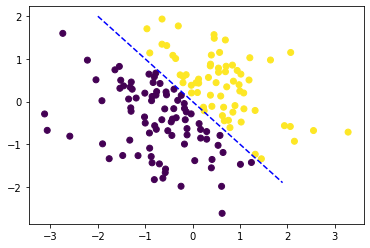

Dataset: http://www.eurecom.fr/~zuluaga/data/dataset2.txt


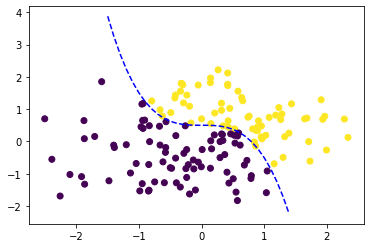

Dataset: http://www.eurecom.fr/~zuluaga/data/dataset3.txt


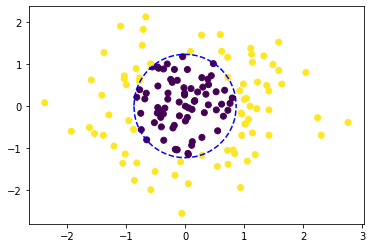

Dataset: http://www.eurecom.fr/~zuluaga/data/dataset4.txt


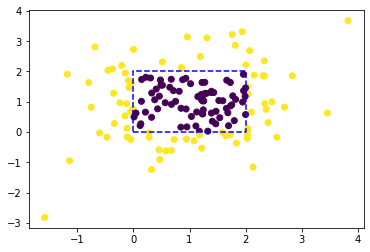

In [88]:
print_dataset(data_path + "/dataset1.txt")
print_dataset(data_path + "/dataset2.txt")
print_dataset(data_path + "/dataset3.txt")
print_dataset(data_path + "/dataset4.txt")


<h4>Question 1</h4>
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

<h4>Your answer</h4>
...

<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

<img src="http://www.eurecom.fr/~zuluaga/data/pseudo_pegasos.png"/>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

<h4>Question 2</h4>
Complete the following implementation of PEGASOS.

<h4>Your answer</h4>

In [0]:

def train_one_iteration(self, learning_rate, eta_t):
    '''
    Train for one epoch according to PEGASOS
    '''
    self.setnextinput() # Picks (x, y) in dataset uniformly at random
    if ### IMPLEMENTATION REQUIRED ###
        new_w = ### IMPLEMENTATION REQUIRED ###
    else:
        new_w = ### IMPLEMENTATION REQUIRED ###
    self.w = new_w

SVM.train_one_iteration = train_one_iteration

<h4>Question 3</h4>
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$). Do you find the results that you forecast in Question 1?

<h4>Your answer</h4>

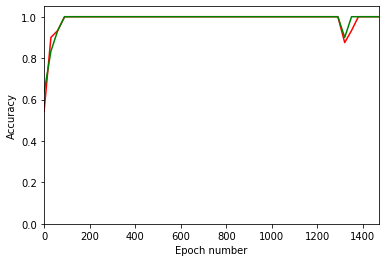

Accuracy: 100.0 %


In [119]:
#from utils import Dataset

# Tests on dataset1
datafile = data_path + "/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = data_path + "/dataset1_test.txt"
test_data = Dataset(test_datafile)

svm = SVM(data, test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

Write your comments in this cell.

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

<h2>Approximating the Radial Basis Function (RBF) kernel</h2>

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

<img src="http://www.eurecom.fr/~zuluaga/data/pseudo_rbf.png"/>

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

<h4>Question 4</h4>
Complete the following implementation of the FeaturesMap class.

<h4>Your answer</h4>

In [0]:
import numpy as np
from math import cos
import random

class FeaturesMap:

    def __init__(self, dim, old_dim, gamma):
        mean = ### IMPLEMENTATION REQUIRED ###
        cov = ### IMPLEMENTATION REQUIRED ###
        self.dim = dim
        self.omega = [np.random.multivariate_normal(mean, cov) for _ in range(dim)]
        self.b = [random.random()*2*PI for _ in range(dim)]

    def __call__(self, dataset):
        outputs = dataset.output
        inputs = []
        for x in dataset.input:
            new_feats = []
            for i in range(self.dim):
                feat = ### IMPLEMENTATION REQUIRED ###
                new_feats.append(feat)
            new_feats = np.array(new_feats)
            new_feats *= np.sqrt(2/self.dim)
            inputs.append(new_feats)
        new_data = Dataset(input_size=self.dim, length=dataset.len)
        new_data.input = inputs
        new_data.output = outputs
        return new_data

<h4>Question 5</h4>
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$. How do your results change with respect to what you found in Question 3?

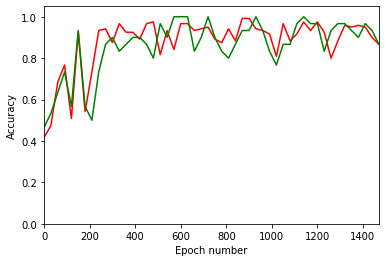

Accuracy: 90.0 %


In [123]:
# Tests on dataset1
datafile = data_path + "/dataset4_train.txt"
data = Dataset(datafile)
test_datafile = data_path + "/dataset4_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

Write your comments in this cell.

<h2>The role of $\gamma$ in the RBF kernel</h2>

<h4>Question 6</h4>
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?

In [106]:

# Tests on dataset1
datafile = data_path + "/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = data_path + "/dataset1_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1e-6)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

NameError: ignored

Write your comments in this cell.

<h4>Question 7</h4>
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?

In [108]:

# Tests on dataset1
datafile = data_path + "/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = data_path + "/dataset1_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1e4)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

NameError: ignored

Write your comments in this cell.